In [262]:
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize


rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from utils import DatabaseEngine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance


In [263]:
import warnings

# Ignore numpy partition warnings
warnings.filterwarnings('ignore', message="Warning: 'partition' will ignore the 'mask' of the MaskedArray.")

### User Satisfaction Analysis

In [264]:
db_engine = DatabaseEngine()
engine = db_engine.create()
clean_df = pd.read_sql_table("clean_xdr_data", con=engine)

Successfully connected to the PostgreSQL "telecom" database


In [265]:
data_df = pd.read_csv('../data/user_info.csv')

In [266]:
df = pd.concat([clean_df, data_df], axis=1)

In [267]:
df['Total Traffic'] = df['Total Download Data'] + df['Total Upload Data']
engagement_metrics = ['Number of Sessions', 'Total Session Duration', 'Total Traffic']

In [268]:
# Function to handle outliers
def replace_with_mean(df, column):
    mean = df[column].mean()
    std = df[column].std()
    is_outlier = (df[column] - mean).abs() > 3*std
    df.loc[is_outlier, column] = mean
    return df

##### User Engagement Score

In [270]:
data_df['Total Traffic'] = data_df['Total Download Data'] + data_df['Total Upload Data']

engagement_metrics = ['Number of Sessions', 'Total Session Duration', 'Total Traffic']
for metric in engagement_metrics:
    data_df = replace_with_mean(data_df, metric)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_df[engagement_metrics])

kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
clusters = kmeans.fit_predict(normalized_data)

data_df['Engagement Cluster'] = clusters

In [271]:
avg_engagement = data_df.groupby('Engagement Cluster')[engagement_metrics].mean()

less_engaged_cluster = avg_engagement.mean(axis=1).idxmin()

centroid = kmeans.cluster_centers_[less_engaged_cluster]

data_df['Engagement Score'] = euclidean_distances(normalized_data, centroid.reshape(1, -1)).flatten()

In [272]:
data_df['Engagement Score'].describe()

count    106856.000000
mean          1.420906
std           1.243147
min           0.014325
25%           0.636431
50%           0.935898
75%           2.033866
max           7.939218
Name: Engagement Score, dtype: float64

##### User Experience Score

In [273]:
clean_df['Total TCP'] = clean_df['TCP UL Retrans. Vol (Bytes)'] + clean_df['TCP DL Retrans. Vol (Bytes)']
clean_df['Total RTT'] = clean_df['Avg RTT DL (ms)'] + clean_df['Avg RTT UL (ms)']
clean_df['Total Throughput'] = clean_df['Avg Bearer TP DL (kbps)'] + clean_df['Avg Bearer TP UL (kbps)']

exp_engagement_metrics = ['Total TCP', 'Total RTT', 'Total Throughput']
for metric in exp_engagement_metrics:
    clean_df = replace_with_mean(clean_df, metric)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(clean_df[exp_engagement_metrics])

kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
exp_clusters = kmeans.fit_predict(normalized_data)

clean_df['Experiance Cluster'] = exp_clusters

In [274]:
exp_avg_engagement = clean_df.groupby('Experiance Cluster')[exp_engagement_metrics].mean()

exp_less_engaged_cluster = exp_avg_engagement.mean(axis=1).idxmin()

exp_centroid = kmeans.cluster_centers_[exp_less_engaged_cluster]

clean_df['Experiance Score'] = euclidean_distances(normalized_data, centroid.reshape(1, -1)).flatten()

In [275]:
clean_df['Experiance Score'].describe()

count    150000.000000
mean          1.365663
std           1.303590
min           0.036061
25%           0.888435
50%           0.928010
75%           1.256111
max          21.042770
Name: Experiance Score, dtype: float64

In [276]:
data_df['MSISDN/Number'] = data_df['MSISDN/Number'].astype(str)
clean_df['MSISDN/Number'] = clean_df['MSISDN/Number'].astype(str)

merged_df = pd.merge(data_df, clean_df, on='MSISDN/Number')

merged_df['Satisfaction Score'] = (merged_df['Experiance Score'] + merged_df['Engagement Score']) / 2

top_10_satisfied_users = merged_df.sort_values('Satisfaction Score', ascending=False).head(10)

In [277]:
merged_df['Satisfaction Score'].describe()

count    148935.000000
mean          1.658673
std           1.013450
min           0.133537
25%           0.879736
50%           1.449997
75%           2.170631
max          13.085117
Name: Satisfaction Score, dtype: float64

In [279]:
top_10_satisfied_customers = merged_df.sort_values('Satisfaction Score', ascending=False).head(10)

top_10_satisfied_customers = top_10_satisfied_customers[['MSISDN/Number', 'Satisfaction Score']]

print(top_10_satisfied_customers.to_string(index=False))

MSISDN/Number  Satisfaction Score
33761630594.0           13.085117
33658835336.0           12.465686
33659964803.0           12.378019
33762171255.0           12.300601
33667756811.0           12.207989
33662157554.0           11.898364
33669105695.0           11.867205
33660845913.0           11.775199
33699438997.0           11.760917
33664016610.0           11.626983


In [280]:
percentiles = merged_df['Satisfaction Score'].describe(percentiles=[0.25, 0.75])

# Define the bins based on percentiles
bins = [percentiles['min'], percentiles['25%'], percentiles['75%'], percentiles['max']]

# Define the labels for each category
labels = ['low satisfaction', 'moderate satisfaction', 'high satisfaction']

# Use pd.cut to categorize the satisfaction scores
merged_df['Satisfaction Category'] = pd.cut(merged_df['Satisfaction Score'], bins=bins, labels=labels, include_lowest=True)

# Display the counts in each category
category_counts = merged_df['Satisfaction Category'].value_counts()
print(category_counts)

Satisfaction Category
moderate satisfaction    74467
low satisfaction         37234
high satisfaction        37234
Name: count, dtype: int64


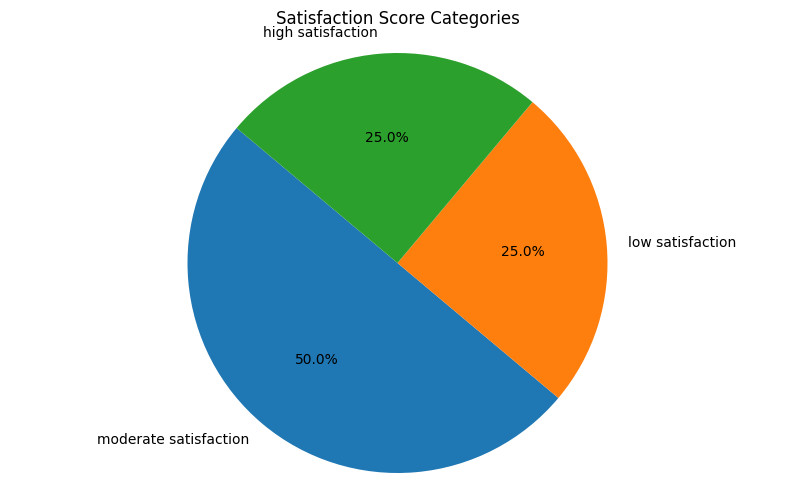

In [281]:
category_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(10, 6))
plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Satisfaction Score Categories')
plt.show()

##### Regression Model

In [282]:
X = merged_df[['Engagement Score', 'Experiance Score']]
y = merged_df['Satisfaction Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

###### Testing the Model

In [283]:
# Define new data
new_data = {'Engagement Score': [1.5], 'Experiance Score': [1.2]}
new_df = pd.DataFrame(new_data)

# Use the model to make a prediction
new_pred = model.predict(new_df)

print(f'The predicted satisfaction score for the new customer is: {new_pred[0]}')

The predicted satisfaction score for the new customer is: 1.35


##### k means clustering, K = 2

In [284]:
X = merged_df[['Engagement Score', 'Experiance Score']]
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans.fit(X)
merged_df['Cluster'] = kmeans.labels_

In [286]:
average_scores = merged_df.groupby('Cluster')[['Satisfaction Score', 'Experiance Score']].mean()

print(average_scores)

         Satisfaction Score  Experiance Score
Cluster                                      
0                  1.162691          1.306654
1                  2.602158          1.474389


##### Exporting the Data to a Database

In [288]:
merged_df.to_sql('user_satisfaction', engine, if_exists='replace', index=False)

337

In [292]:
query = "SELECT * FROM user_satisfaction LIMIT 5;"
query_df = pd.read_sql_query(query, engine)
query_df

,MSISDN/Number,Number of Sessions,Total Session Duration,Total Download Data,Total Upload Data,Social Media Download Data,Social Media Upload Data,Google Download Data,Google Upload Data,Email Download Data,...,Total UL (Bytes),Total DL (Bytes),Total TCP,Total RTT,Total Throughput,Experiance Cluster,Experiance Score,Satisfaction Score,Satisfaction Category,Cluster
0,3197020876596.0,1.0,146167.156323,194828056.0,37295915.0,668596.0,46628.0,8572779.0,1865881.0,842279.0,...,37295915.0,194828056.0,2.156957e+07,127.458589,1.0,1,1.025659,0.914950,moderate satisfaction,0
1,33601001722.0,1.0,116720.000000,842637466.0,36053108.0,2206504.0,25631.0,3337123.0,1051882.0,837400.0,...,36053108.0,842637466.0,2.156957e+07,46.000000,76.0,1,0.885856,0.934504,moderate satisfaction,0
2,33601001754.0,1.0,181230.000000,120755184.0,36104459.0,2598548.0,62017.0,4197697.0,1137166.0,2828821.0,...,36104459.0,120755184.0,2.156957e+07,31.000000,99.0,1,0.901403,1.031410,moderate satisfaction,0
3,33601002511.0,1.0,134969.000000,556659663.0,39306820.0,3148004.0,47619.0,3343483.0,99643.0,2436500.0,...,39306820.0,556659663.0,2.156957e+07,127.458589,97.0,1,1.024765,0.722675,low satisfaction,0
4,33601007832.0,1.0,49878.000000,401993172.0,20327526.0,251469.0,28825.0,5937765.0,3740728.0,2178618.0,...,20327526.0,401993172.0,7.607247e+05,84.000000,248.0,1,0.412206,0.462616,low satisfaction,0
